## Binary Classification with ROC Curve : Decision Tree vs Random Forest



Loading monitored datafile...
Total monitored samples: 19000
Loading unmonitored datafile...
Total combined samples: 22000


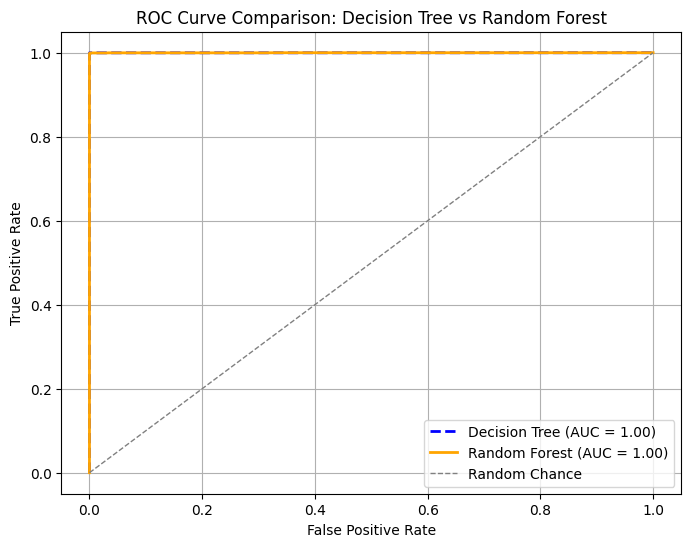

Decision Tree Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       590
           1       1.00      1.00      1.00      3810

    accuracy                           1.00      4400
   macro avg       1.00      1.00      1.00      4400
weighted avg       1.00      1.00      1.00      4400


Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.95      0.97       590
           1       0.99      1.00      1.00      3810

    accuracy                           0.99      4400
   macro avg       1.00      0.98      0.99      4400
weighted avg       0.99      0.99      0.99      4400



In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt


def load_data():
    # Monitored data
    TOTAL_URLS = 950
    URL_PER_SITE = 10
    USE_SUBLABEL = False

    print("Loading monitored datafile...")
    with open("/content/sample_data/mon_standard.pkl", "rb") as file:
        data = pickle.load(file)

    X_timestamps, X_packet_sizes, X_cum_sizes, y_monitored = [], [], [], []

    for i in range(TOTAL_URLS):
        label = i if USE_SUBLABEL else i // URL_PER_SITE
        for sample in data[i]:
            timestamps = np.empty(len(sample), dtype=np.float32)
            packet_sizes = np.empty(len(sample), dtype=np.int16)
            cum_sizes = np.empty(len(sample), dtype=np.int32)

            cumulative_sum = 0
            for j, c in enumerate(sample):
                dr = 1 if c > 0 else -1
                timestamps[j] = abs(c)
                packet_sizes[j] = dr * 512
                cumulative_sum += packet_sizes[j]
                cum_sizes[j] = cumulative_sum

            X_timestamps.append(timestamps)
            X_packet_sizes.append(packet_sizes)
            X_cum_sizes.append(cum_sizes)
            y_monitored.append(label)

    print(f"Total monitored samples: {len(y_monitored)}")

    # Unmonitored data
    TOTAL_UNMON_URLS = 3000

    print("Loading unmonitored datafile...")
    with open("/content/sample_data/unmon_standard10_3000.pkl", "rb") as f:
        x = pickle.load(f)

    for i in range(TOTAL_UNMON_URLS):
        sample = x[i]
        timestamps = np.empty(len(sample), dtype=np.float32)
        packet_sizes = np.empty(len(sample), dtype=np.int16)
        cum_sizes = np.empty(len(sample), dtype=np.int32)

        cumulative_sum = 0
        for j, c in enumerate(sample):
            dr = 1 if c > 0 else -1
            timestamps[j] = abs(c)
            packet_sizes[j] = dr * 512
            cumulative_sum += packet_sizes[j]
            cum_sizes[j] = cumulative_sum

        X_timestamps.append(timestamps)
        X_packet_sizes.append(packet_sizes)
        X_cum_sizes.append(cum_sizes)
        y_monitored.append(-1)

    print(f"Total combined samples: {len(y_monitored)}")

    return X_timestamps, X_packet_sizes, X_cum_sizes, y_monitored

# padding function
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=np.float32)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = seq[:maxlen]
    return padded_sequences


X_timestamps, X_packet_sizes, X_cum_sizes, y_monitored = load_data()

# padding
max_length = max(len(seq) for seq in X_timestamps)
X_timestamps_padded = pad_sequences(X_timestamps, max_length)
X_packet_sizes_padded = pad_sequences(X_packet_sizes, max_length)
X_cum_sizes_padded = pad_sequences(X_cum_sizes, max_length)

# feature combination
X_combined = np.hstack((X_timestamps_padded, X_packet_sizes_padded, X_cum_sizes_padded))

# data split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_monitored, test_size=0.2, random_state=42)

# Binary Classification 
binary_y_train = np.where(np.array(y_train) == -1, -1, 1)  # Monitored(1), Unmonitored(-1)
binary_y_test = np.where(np.array(y_test) == -1, -1, 1)

# model 
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

decision_tree.fit(X_train, binary_y_train)
random_forest.fit(X_train, binary_y_train)

# ROC Curve 
dt_probs = decision_tree.predict_proba(X_test)[:, 1]
rf_probs = random_forest.predict_proba(X_test)[:, 1]

dt_fpr, dt_tpr, _ = roc_curve(binary_y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(binary_y_test, rf_probs)

# AUC 
dt_auc = auc(dt_fpr, dt_tpr)
rf_auc = auc(rf_fpr, rf_tpr)

# ROC Curve visualization
plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})', linestyle='--', color='blue', linewidth=2)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', linestyle='-', color='orange', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance', linewidth=1)
plt.title('ROC Curve Comparison: Decision Tree vs Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Report
binary_y_pred_dt = decision_tree.predict(X_test)
binary_y_pred_rf = random_forest.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(binary_y_test, binary_y_pred_dt))
print("\nRandom Forest Classification Report:")
print(classification_report(binary_y_test, binary_y_pred_rf))
